In [1]:
!pip install fastparquet

import numpy as np
import pandas as pd
import time
import warnings

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_validate, RandomizedSearchCV

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier, plot_importance

from math import sqrt
import seaborn as sns
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 67.2 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Read the processed dataset.
semg_df = pd.read_parquet('/content/drive/MyDrive/sEMG-HAR/semg_extracted_more_features_detrended', engine='fastparquet')


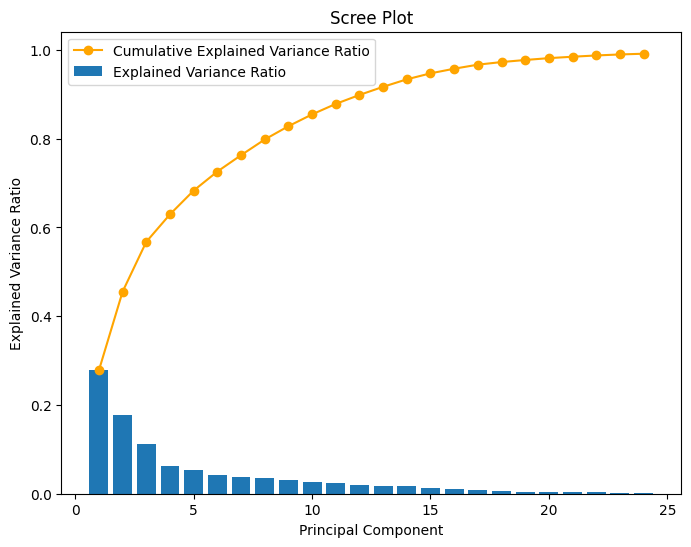

In [5]:
X = semg_df[['semg_1_td_mean', 'semg_2_td_mean', 'semg_3_td_mean', 'semg_4_td_mean', 'semg_5_td_mean',
            'semg_1_td_rms', 'semg_2_td_rms', 'semg_3_td_rms', 'semg_4_td_rms', 'semg_5_td_rms',
            'semg_1_td_sd', 'semg_2_td_sd', 'semg_3_td_sd', 'semg_4_td_sd', 'semg_5_td_sd',
            'semg_1_td_var', 'semg_2_td_var', 'semg_3_td_var', 'semg_4_td_var', 'semg_5_td_var',
            'semg_1_td_iemg', 'semg_2_td_iemg', 'semg_3_td_iemg', 'semg_4_td_iemg', 'semg_5_td_iemg',
            'semg_1_td_zcr', 'semg_2_td_zcr', 'semg_3_td_zcr', 'semg_4_td_zcr', 'semg_5_td_zcr',
            'semg_1_td_ssc', 'semg_2_td_ssc', 'semg_3_td_ssc', 'semg_4_td_ssc', 'semg_5_td_ssc',
            'semg_1_td_wfl', 'semg_2_td_wfl', 'semg_3_td_wfl', 'semg_4_td_wfl', 'semg_5_td_wfl',
            'semg_1_fd_medfreq', 'semg_1_fd_meanfreq',
            'semg_2_fd_medfreq', 'semg_2_fd_meanfreq',
            'semg_3_fd_medfreq', 'semg_3_fd_meanfreq',
            'semg_4_fd_medfreq', 'semg_4_fd_meanfreq',
            'semg_5_fd_medfreq', 'semg_5_fd_meanfreq',]]


y = semg_df['activity']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# Apply PCA
pca = PCA(n_components=0.99)  # Preserve 99% of the total variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.fit_transform(X_test_scaled)

# Plot the scree plot
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, align='center', label='Explained Variance Ratio')
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, marker='o', color='orange', label='Cumulative Explained Variance Ratio')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.legend()
plt.show()




In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Train the model for different learning rates and check results:
lr_list = [0.25, 0.5, 0.75, 1]
# lr_list = [0.25]
train_accuracy_list = []
test_accuracy_list = []
precision_list = []
f1_list = []
recall_list = []

for learning_rate in lr_list:

    # get the start time
    st = time.time()

    gb_clf = GradientBoostingClassifier(n_estimators=5, learning_rate=learning_rate, max_depth=2, random_state=0)
    gb_clf.fit(X_train, y_train)
    # get the end time
    et = time.time()

    # get the execution time
    elapsed_time = et - st
    print('Modelling training time:', elapsed_time, 'seconds')

    print("\n\n###### Learning rate: ", learning_rate)
    train_accuracy_score = gb_clf.score(X_train, y_train)
    train_accuracy_list.append(train_accuracy_score)
    test_accuracy_score = gb_clf.score(X_test, y_test)
    test_accuracy_list.append(test_accuracy_score)
    print("Accuracy score (training): {0:.3f}".format(train_accuracy_score))
    print("Accuracy score (testing): {0:.3f}".format(test_accuracy_score))

    accuracy_scores = cross_val_score(gb_clf, X, y, cv=5, scoring='accuracy')
    precision_scores = cross_val_score(gb_clf, X, y, cv=5, scoring='precision_macro')
    recall_scores = cross_val_score(gb_clf, X, y, cv=5, scoring='recall_macro')
    f1_scores = cross_val_score(gb_clf, X, y, cv=5, scoring='f1_macro')

    print("CROSS VALIDATION SCORES: ")
    print("Accuracy Score: ", np.mean(accuracy_scores))
    print("Precision Score: ", np.mean(precision_scores))
    precision_list.append(np.mean(precision_scores))
    print("Recall Score: ", np.mean(recall_scores))
    recall_list.append(np.mean(recall_scores))
    print("F1 Score: ", np.mean(f1_scores))
    f1_list.append(np.mean(f1_scores))

    # # Calculate and print the confusion matrix
    # y_test_pred = gb_clf.predict(X_test)
    # conf_matrix = confusion_matrix(y_test, y_test_pred)
    # disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

    # fig, ax = plt.subplots(figsize=(10, 10))
    # disp.plot(ax=ax, cmap='viridis', values_format='d')

    # # Add titles and labels
    # ax.set_title('Confusion Matrix')
    # ax.set_xlabel('Predicted Labels')
    # ax.set_ylabel('True Labels')
    # plt.xticks(rotation=90)
    # plt.show()
    print("############################")

# sns.lineplot(x = lr_list, y = train_accuracy_list, marker = 'o')
# sns.lineplot(x = lr_list, y = test_accuracy_list, marker = 'o')
# plt.xlabel("Learning Rate")
# plt.ylabel("Testing Accuracy Scores")
# plt.legend()
# plt.show()


Modelling training time: 1.1499793529510498 seconds


###### Learning rate:  0.25
Accuracy score (training): 0.851
Accuracy score (testing): 0.572
CROSS VALIDATION SCORES: 
Accuracy Score:  0.6037612693833394
Precision Score:  0.6249301625528958
Recall Score:  0.6042568542568543
F1 Score:  0.5987449213482006
############################
Modelling training time: 1.138087272644043 seconds


###### Learning rate:  0.5
Accuracy score (training): 0.885
Accuracy score (testing): 0.602
CROSS VALIDATION SCORES: 
Accuracy Score:  0.5927298954201226
Precision Score:  0.608714031026061
Recall Score:  0.5934343434343434
F1 Score:  0.5904591245562965
############################
Modelling training time: 1.1435878276824951 seconds


###### Learning rate:  0.75
Accuracy score (training): 0.756
Accuracy score (testing): 0.475


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CROSS VALIDATION SCORES: 
Accuracy Score:  0.5059754778218536
Precision Score:  0.5336509164305862
Recall Score:  0.5060606060606061
F1 Score:  0.5029879086735896
############################
Modelling training time: 1.139787197113037 seconds


###### Learning rate:  1
Accuracy score (training): 0.365
Accuracy score (testing): 0.258


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CROSS VALIDATION SCORES: 
Accuracy Score:  0.24079697078975837
Precision Score:  0.23171987758082793
Recall Score:  0.24047619047619043
F1 Score:  0.2110686131567899
############################


In [7]:
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]
# lr_list = [0.75]
train_accuracy_list = []
test_accuracy_list = []

eval_set = [(X_train, y_train - 1), (X_test, y_test - 1)]

for lr in lr_list:
    print("\n\n######## Learning Rate: ", lr)
    xgb_clf = XGBClassifier(learning_rate = lr, n_estimators=45, max_depth=2,
#                             subsample=1.0, colsample_bytree=1.0,
#                             gamma=0.2, alpha=0.1, reg_lambda=0.1
                           )
    # get the start time
    st = time.time()

    xgb_clf.fit(X_train, y_train - 1,
#                 eval_metric="merror", eval_set=eval_set, early_stopping_rounds=5
               )
    # get the end time
    et = time.time()

    # get the execution time
    elapsed_time = et - st
    print('Modelling training time:', elapsed_time, 'seconds')

    # Calculate and print accuracy
    test_score = xgb_clf.score(X_test, y_test - 1)
    print("Testing Accuracy Score: ", test_score)
    train_score = xgb_clf.score(X_train, y_train - 1)
    print("Training Accuracy Score", train_score)

    test_accuracy_list.append(test_score)
    train_accuracy_list.append(train_score)

    # Calculate and print precision, recall, and F1 score for test set
    y_test_pred = xgb_clf.predict(X_test)
    test_precision = precision_score(y_test - 1, y_test_pred, average='weighted')
    test_recall = recall_score(y_test - 1, y_test_pred, average='weighted')
    test_f1 = f1_score(y_test - 1, y_test_pred, average='weighted')
    print("Testing Precision: ", test_precision)
    print("Testing Recall: ", test_recall)
    print("Testing F1 Score: ", test_f1)

    # # Calculate and print the confusion matrix
    # y_test_pred = gb_clf.predict(X_test)
    # conf_matrix = confusion_matrix(y_test - 1, y_test_pred)
    # disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

    # fig, ax = plt.subplots(figsize=(10, 10))
    # disp.plot(ax=ax, cmap='viridis', values_format='d')

    # # Add titles and labels
    # ax.set_title('Confusion Matrix')
    # ax.set_xlabel('Predicted Labels')
    # ax.set_ylabel('True Labels')
    # plt.xticks(rotation=90)
    # plt.show()
    print("############################")

# sns.lineplot(x = lr_list, y = train_accuracy_list, marker = 'o')
# sns.lineplot(x = lr_list, y = test_accuracy_list, marker = 'o')
# plt.xlabel("Learning Rate")
# plt.ylabel("Testing Accuracy Scores")
# plt.legend()
# plt.show()




######## Learning Rate:  0.05
Modelling training time: 0.9791810512542725 seconds
Testing Accuracy Score:  0.6228813559322034
Training Accuracy Score 0.8606382978723405
Testing Precision:  0.6436146421845576
Testing Recall:  0.6228813559322034
Testing F1 Score:  0.6155086497645021
############################


######## Learning Rate:  0.075
Modelling training time: 3.4671754837036133 seconds
Testing Accuracy Score:  0.652542372881356
Training Accuracy Score 0.9053191489361702
Testing Precision:  0.6713383658548165
Testing Recall:  0.652542372881356
Testing F1 Score:  0.650311631697671
############################


######## Learning Rate:  0.1
Modelling training time: 0.8861753940582275 seconds
Testing Accuracy Score:  0.6779661016949152
Training Accuracy Score 0.9340425531914893
Testing Precision:  0.7076287468485873
Testing Recall:  0.6779661016949152
Testing F1 Score:  0.6770706801795601
############################


######## Learning Rate:  0.25
Modelling training time: 0.82637